In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q --upgrade transformers diffusers ftfy accelerate

In [3]:
# setup imports to get basic libraries

from base64 import b64encode

import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# video display to show transition
from IPython.display import HTML
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1024)

# huggingface login - use token from huggingface user profile when prompted
# DO NOT HARDCODE OR SAVE IT
if not (Path.home()/'.cache/huggingface'/'token').exists():
    notebook_login()
    
# suppress warnings during CLIPTextModel
logging.set_verbosity_error()

# set default device to cuda when available
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
## code similar to huggingface example notebook

# these are the key components - model names upfront in case this needs to be migrated to other models
diffusion_model = "CompVis/stable-diffusion-v1-4"
text_tokenizer_model = "openai/clip-vit-large-patch14"

#1 Autoencoder to decode latents into images
vae = AutoencoderKL.from_pretrained(diffusion_model, subfolder = "vae")

#2 Tokenizer and Text Encoder for text
tokenizer = CLIPTokenizer.from_pretrained(text_tokenizer_model)
text_encoder = CLIPTextModel.from_pretrained(text_tokenizer_model)

#3 UNet model :)
unet = UNet2DConditionModel.from_pretrained(diffusion_model, subfolder = "unet")

#4 Noise scheduler
scheduler = LMSDiscreteScheduler(
    beta_start = 0.00085,
    beta_end = 0.012,
    beta_schedule = "scaled_linear",
    num_train_timesteps = 1000
)

# push to GPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [5]:
# hugging face reference notebook - https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb

# Parameters for this iteration
prompt = ["A watercolor painting of a stray black and white dog"]
height = 512 # default
width = 512 # default
num_inference_steps = 30 # denoising steps
guidance_scale = 7.5 # scale for classifier free guidance
generator = torch.manual_seed(20)
batch_size = 1

# Text encoding and embedding using base prompt(s)
text_input = tokenizer(
    prompt,
    padding = "max_length",
    max_length = tokenizer.model_max_length,
    truncation = True,
    return_tensors = "pt" # pt stands for pytorch :)
)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    # gradients don't need to be updated during image generation; this saves computational resources

# uncond_input is not conditioned on any prompt - this is meant to mimic the structure of the text prompt above
# it represents the starting point for noise diffusion process without any external guidance
max_length = text_input.input_ids.shape[-1] # anchored to the text prompt
uncond_input = tokenizer(
    [""]*batch_size, # depending on # of batches of text, this could be expanded
    padding = "max_length",
    max_length = max_length,
    return_tensors = "pt" # pt stands for pytorch
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Noise scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

set_timesteps(scheduler, num_inference_steps)

# Latent images - initialized to serve as a starting point
latents = torch.randn(
    (batch_size, unet.in_channels, height//8, width//8), # compress 8-fold
    generator = generator
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # scaling

/tmp/ipykernel_33/3169011817.py:46: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height//8, width//8), # compress 8-fold


  0%|          | 0/30 [00:00<?, ?it/s]

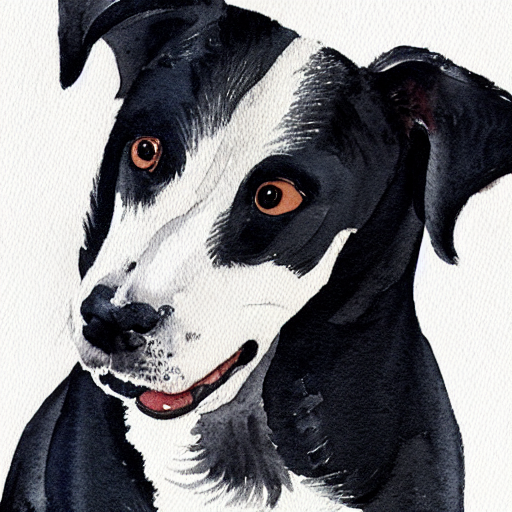

In [6]:
# diffusion loop!
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps), total = len(scheduler.timesteps)):
        
        # expand latents if doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        
        # scale latents (preconditioning)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        
        # predict noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states = text_embeddings).sample
        
        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        # compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
# scale and decode image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [8]:
# break down into components

# PIL = Python Imaging Library

# autoencoder
def pil_to_latent(input_image):
    # turn single image into a latent in a batch
    with torch.no_grad():
        # use pre-trained vae to convert to tensor
        # unsqueeze: add a single dimension of size 1 at beginning
        # normalize pixel values to between -1 and 1
        latent = vae.encode(tfms.ToTensor()(input_image).unsqueeze(0).to(torch_device)*2 - 1)
        
    # sampling (likely) introduces some randomness; scale factor ensures the initial latent space has unit variance
    # paper https://arxiv.org/pdf/2112.10752
    return 0.18215 * latent.latent_dist.sample()

# autoencoder decoder
def latents_to_pil(latents):
    # reverse scaling
    latents = (1/0.18215) * latents
    with torch.no_grad():
        # decode sample
        image = vae.decode(latents).sample
    
    # normalize, shift from -1 and 1 to 0 to 1 and clamp values in that range
    image = (image/2 + 0.5).clamp(0, 1)
    
    # permute used to convert tensor to image, with channels as last dimension
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    
    # convert to format expected by PIL images (scale to 255, round, convert to unsigned 8 bit integers)
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images    

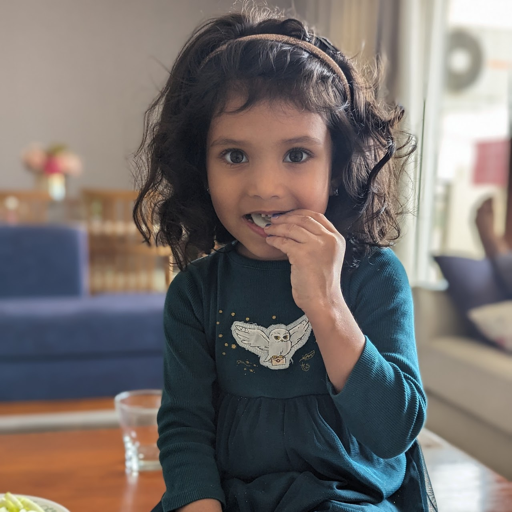

In [14]:
# get image
img_url = '/kaggle/input/personal-tests/avy.jpg'
input_img = Image.open(img_url).resize((512, 512))
input_img

Encoded shape:  torch.Size([1, 4, 64, 64])


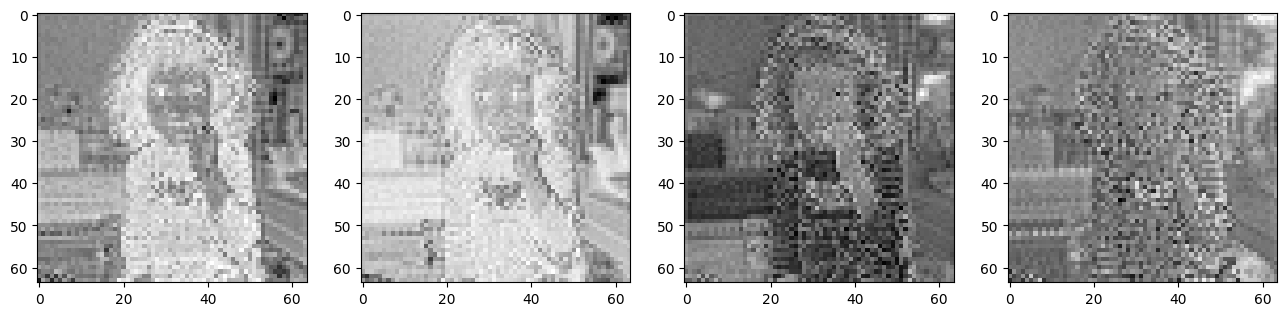

In [22]:
# turn image into latent space
encoded_img = pil_to_latent(input_img)
print("Encoded shape: ", encoded_img.shape)

# visualize channels in encoded latent
fig, axs = plt.subplots(1, 4, figsize = (16, 4))
for c in range(4):
    axs[c].imshow(encoded_img[0][c].cpu(), cmap = 'Greys')

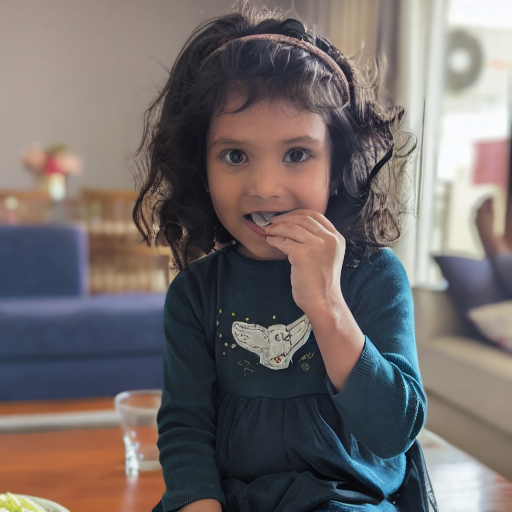

In [23]:
# test decoder
decoded = latents_to_pil(encoded_img)[0]
decoded

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000])
tensor([14.6146,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000])


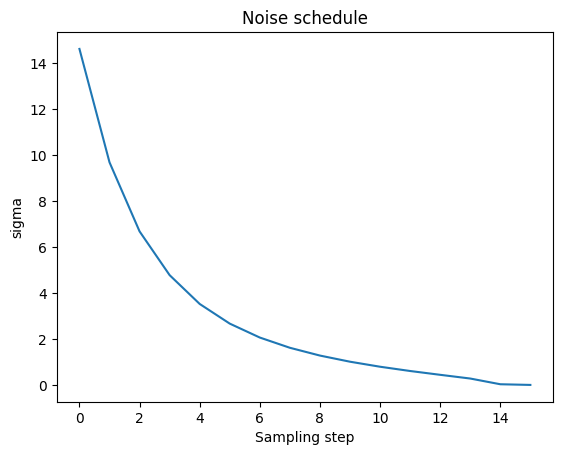

In [25]:
## scheduler
# handles all details during sampling
# when we want to denoise over a number of steps ..
# how many steps & how much noise should we aim for at each step

# set # of sampling steps
# scheduler = LMSdiscreteScheduler
set_timesteps(scheduler, 15)

print(scheduler.timesteps) # original 1000 steps
print(scheduler.sigmas) # equivalent noise levels

# plot noise schedule
plt.plot(scheduler.sigmas)
plt.title('Noise schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

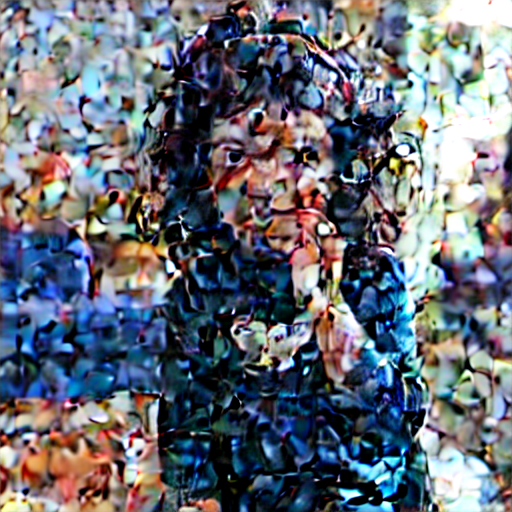

In [34]:
# test adding some noise to the latent representation

# random noise of the encoded image shape
noise = torch.randn_like(encoded_img) 

# step 10 out of 15
sampling_step = 10

# add noise to latent - scaled by sigma, i.e. noisy_samples = original_samples + noise*sigmas
encoded_and_noised_img = scheduler.add_noise(
    encoded_img, 
    noise, 
    timesteps = torch.tensor([scheduler.timesteps[sampling_step]])
)

# convert latent to image and display image
latents_to_pil(encoded_and_noised_img.float())[0]

  0%|          | 0/50 [00:00<?, ?it/s]

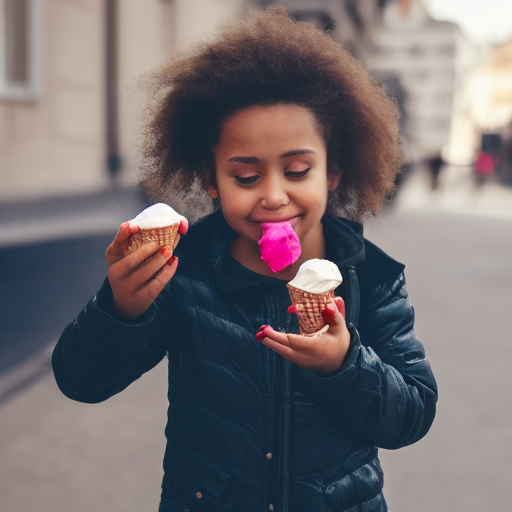

In [38]:
# test image 2 image version loop
# similar loop as the first one but skip the start_step

# settings, new prompt
prompt = ["A girl eating ice cream"]
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(1024)
batch_size = 1

# prepare text
text_input = tokenizer(
    prompt,
    padding = "max_length",
    max_length = tokenizer.model_max_length,
    truncation = True,
    return_tensors = "pt" # pytorch tensor
)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""]*batch_size,
    padding = "max_length",
    max_length = max_length,
    return_tensors = "pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# prep scheduler
set_timesteps(scheduler, num_inference_steps)

# prep latents
start_step = 10
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded_img)
latents = scheduler.add_noise(
    encoded_img,
    noise,
    timesteps = torch.tensor([scheduler.timesteps[start_step]])
)
latents = latents.to(torch_device).float()

# run loop based on timesteps
for i, t in tqdm(enumerate(scheduler.timesteps), total = len(scheduler.timesteps)):
    if i >= start_step: # start after step 10 since we already added noise
        
        # expand latents if doing cfg
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        
        # predict noise residual
        with torch.no_grad():
            noise_pred = unet(
                latent_model_input, 
                t,
                encoder_hidden_states = text_embeddings
            )["sample"]
        
        # perform guidance based on scale to which prompt should tip
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        # compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
latents_to_pil(latents)[0]